<a href="https://colab.research.google.com/github/haikalashari/Rakamin-X-Home-Credit-Project-Based-Internship/blob/main/Rakamin_Final_Task_Muhammad%20Haikal%20Ashari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')

print(df_train.shape)
print(df_test.shape)
print(df_train['TARGET'].value_counts(normalize=True))
print(df_train.isnull().sum().sort_values(ascending=False).head(10))

(307511, 122)
(48744, 121)
TARGET
0   0.92
1   0.08
Name: proportion, dtype: float64
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
dtype: int64


# Data Preprocessing

In [ ]:
cols_to_abs = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

for col in cols_to_abs:
    if col in df_train.columns:
        df_train[col] = df_train[col].abs()
    if col in df_test.columns:
        df_test[col] = df_test[col].abs()

# Data Cleaning

In [ ]:
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)
df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].replace(365243, np.nan)

df_train = df_train[df_train['CODE_GENDER'] != 'XNA'].copy()

anomali_check = (df_train['DAYS_EMPLOYED'] == 365243).sum()
print(anomali_check)

0


# Agregation With Other Data

In [ ]:
df_prev = pd.read_csv('previous_application.csv')
df_bureau = pd.read_csv('bureau.csv')
df_install = pd.read_csv('installments_payments.csv')

prev_agg = df_prev[df_prev['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR').size().reset_index(name='CNT_REFUSED_HISTORY')

bureau_agg = df_bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max().reset_index(name='MAX_BUREAU_OVERDUE')

df_install['IS_LATE'] = (df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']) > 0
install_agg = df_install.groupby('SK_ID_CURR')['IS_LATE'].mean().reset_index(name='LATE_PAYMENT_RATIO')

def merge_risk_features(df):
    df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
    df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
    df = df.merge(install_agg, on='SK_ID_CURR', how='left')

    cols = ['CNT_REFUSED_HISTORY', 'MAX_BUREAU_OVERDUE', 'LATE_PAYMENT_RATIO']
    df[cols] = df[cols].fillna(0)
    return df

df_train = merge_risk_features(df_train)
df_test = merge_risk_features(df_test)

# Feature Selection

Jumlah Fitur Numerik    : 75
Jumlah Fitur Kategorikal: 48


/tmp/ipython-input-228297744.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=top_num, ax=axes[0], palette='Blues_r')
/tmp/ipython-input-228297744.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Score', y='Feature', data=top_cat, ax=axes[1], palette='Oranges_r')


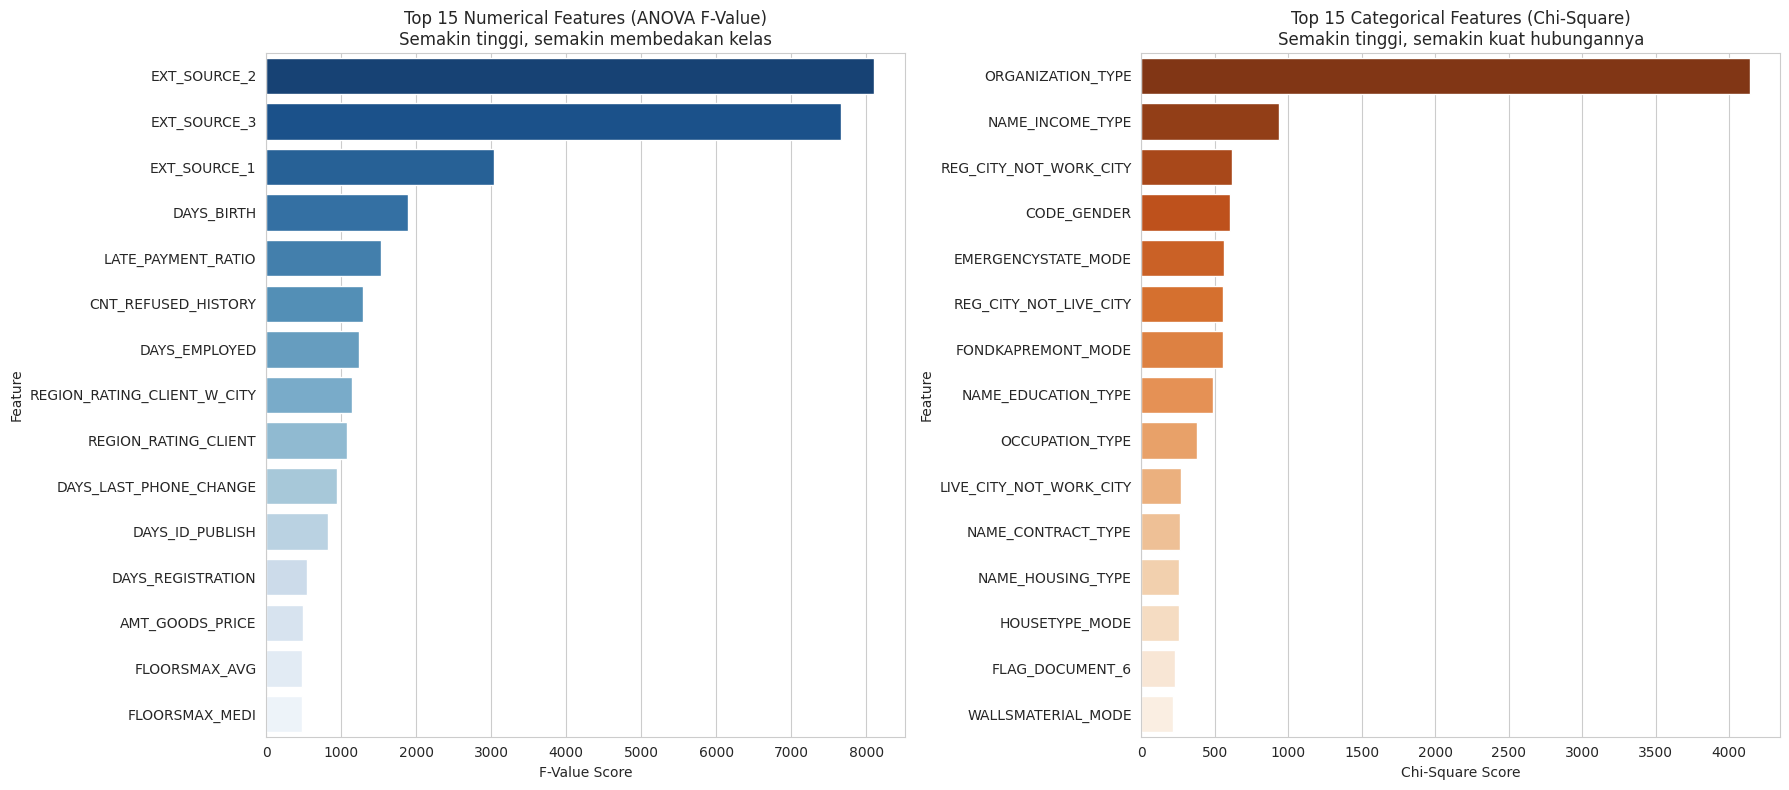


TOP 10 NUMERICAL:
                        Feature   Score
16                 EXT_SOURCE_2 8109.49
17                 EXT_SOURCE_3 7659.89
15                 EXT_SOURCE_1 3036.65
6                    DAYS_BIRTH 1894.09
74           LATE_PAYMENT_RATIO 1536.34
72          CNT_REFUSED_HISTORY 1295.61
7                 DAYS_EMPLOYED 1239.70
13  REGION_RATING_CLIENT_W_CITY 1144.52
12         REGION_RATING_CLIENT 1070.55
65       DAYS_LAST_PHONE_CHANGE  940.49

TOP 10 CATEGORICAL:
                    Feature   Score
23        ORGANIZATION_TYPE 4139.06
5          NAME_INCOME_TYPE  934.96
21   REG_CITY_NOT_WORK_CITY  615.32
1               CODE_GENDER  605.97
27      EMERGENCYSTATE_MODE  561.01
20   REG_CITY_NOT_LIVE_CITY  558.67
24       FONDKAPREMONT_MODE  556.29
6       NAME_EDUCATION_TYPE  486.73
15          OCCUPATION_TYPE  376.23
22  LIVE_CITY_NOT_WORK_CITY  266.76


In [ ]:
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# ==============================================================================
# 1. PERSIAPAN DATA
# ==============================================================================
# Pisahkan X dan y
X_fs = df_train.drop(columns=['TARGET', 'SK_ID_CURR']).copy()
y_fs = df_train['TARGET']

# Identifikasi Tipe Kolom
# Catatan: Kolom 'int64' yang isinya cuma 0 dan 1 (Flag) sebaiknya masuk kategori
cat_cols = [c for c in X_fs.columns if X_fs[c].dtype == 'object' or len(X_fs[c].unique()) <= 2]
num_cols = [c for c in X_fs.columns if c not in cat_cols]

print(f"Jumlah Fitur Numerik    : {len(num_cols)}")
print(f"Jumlah Fitur Kategorikal: {len(cat_cols)}")

# ==============================================================================
# 2. PROSES FITUR NUMERIK (ANOVA F-VALUE)
# ==============================================================================
# Imputasi Median dulu (ANOVA tidak bisa baca NaN)
X_num = X_fs[num_cols].fillna(X_fs[num_cols].median())

# Hitung F-Score
f_scores, p_values = f_classif(X_num, y_fs)

# Buat DataFrame Hasil Numerik
df_num_scores = pd.DataFrame({
    'Feature': num_cols,
    'Score': f_scores,
    'Type': 'Numerical (ANOVA)'
}).sort_values(by='Score', ascending=False)

# ==============================================================================
# 3. PROSES FITUR KATEGORIKAL (CHI-SQUARE)
# ==============================================================================
# Chi2 butuh angka non-negatif. Kita pakai OrdinalEncoder.
X_cat = X_fs[cat_cols].astype(str) # Pastikan string semua
oe = OrdinalEncoder()
X_cat_encoded = oe.fit_transform(X_cat)

# Chi-Square Test
chi2_scores, p_values_cat = chi2(X_cat_encoded, y_fs)

# Buat DataFrame Hasil Kategorikal
df_cat_scores = pd.DataFrame({
    'Feature': cat_cols,
    'Score': chi2_scores,
    'Type': 'Categorical (Chi2)'
}).sort_values(by='Score', ascending=False)

# ==============================================================================
# 4. GABUNGKAN & VISUALISASI
# ==============================================================================
# Kita ambil Top 15 dari masing-masing kategori untuk ditampilkan
top_num = df_num_scores.head(15)
top_cat = df_cat_scores.head(15)

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot Numerik
sns.barplot(x='Score', y='Feature', data=top_num, ax=axes[0], palette='Blues_r')
axes[0].set_title('Top 15 Numerical Features (ANOVA F-Value)\nSemakin tinggi, semakin membedakan kelas')
axes[0].set_xlabel('F-Value Score')

# Plot Kategorikal
sns.barplot(x='Score', y='Feature', data=top_cat, ax=axes[1], palette='Oranges_r')
axes[1].set_title('Top 15 Categorical Features (Chi-Square)\nSemakin tinggi, semakin kuat hubungannya')
axes[1].set_xlabel('Chi-Square Score')

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. MENAMPILKAN DAFTAR FITUR FINAL (GABUNGAN)
# ==============================================================================
print("\nTOP 10 NUMERICAL:")
print(df_num_scores[['Feature', 'Score']].head(10))
print("\nTOP 10 CATEGORICAL:")
print(df_cat_scores[['Feature', 'Score']].head(10))

In [ ]:
file_name_scores = 'feature_selection_scores.xlsx'

with pd.ExcelWriter(file_name_scores) as writer:
    df_num_scores.to_excel(writer, sheet_name='Numerical_ANOVA', index=False)

    df_cat_scores.to_excel(writer, sheet_name='Categorical_Chi2', index=False)

print("   -> Sheet 1: Numerical_ANOVA")
print("   -> Sheet 2: Categorical_Chi2")

print("\nPreview Top 5 Numerik:")
print(df_num_scores.head())
print("\nPreview Top 5 Kategorikal:")
print(df_cat_scores.head())

   -> Sheet 1: Numerical_ANOVA
   -> Sheet 2: Categorical_Chi2

Preview Top 5 Numerik:
               Feature   Score               Type
16        EXT_SOURCE_2 8109.49  Numerical (ANOVA)
17        EXT_SOURCE_3 7659.89  Numerical (ANOVA)
15        EXT_SOURCE_1 3036.65  Numerical (ANOVA)
6           DAYS_BIRTH 1894.09  Numerical (ANOVA)
74  LATE_PAYMENT_RATIO 1536.34  Numerical (ANOVA)

Preview Top 5 Kategorikal:
                   Feature   Score                Type
23       ORGANIZATION_TYPE 4139.06  Categorical (Chi2)
5         NAME_INCOME_TYPE  934.96  Categorical (Chi2)
21  REG_CITY_NOT_WORK_CITY  615.32  Categorical (Chi2)
1              CODE_GENDER  605.97  Categorical (Chi2)
27     EMERGENCYSTATE_MODE  561.01  Categorical (Chi2)


In [ ]:
# Feature Engginering
df_train['IS_PRIME_WORKING_PROFILE'] = ((df_train['NAME_FAMILY_STATUS'] == 'Married') & (df_train['NAME_HOUSING_TYPE'] == 'House / apartment') & (df_train['NAME_INCOME_TYPE'] == 'Working')).astype(int)
risk_score_train = (df_train['CNT_REFUSED_HISTORY'] > 0).astype(int) + (df_train['MAX_BUREAU_OVERDUE'] > 0).astype(int) + (df_train['LATE_PAYMENT_RATIO'] > 0.05).astype(int)
df_train['PRIME_WORKING_RISK_INTERACTION'] = df_train['IS_PRIME_WORKING_PROFILE'] * risk_score_train

# Test Set
df_test['IS_PRIME_WORKING_PROFILE'] = ((df_test['NAME_FAMILY_STATUS'] == 'Married') & (df_test['NAME_HOUSING_TYPE'] == 'House / apartment') & (df_test['NAME_INCOME_TYPE'] == 'Working')).astype(int)
risk_score_test = (df_test['CNT_REFUSED_HISTORY'] > 0).astype(int) + (df_test['MAX_BUREAU_OVERDUE'] > 0).astype(int) + (df_test['LATE_PAYMENT_RATIO'] > 0.05).astype(int)
df_test['PRIME_WORKING_RISK_INTERACTION'] = df_test['IS_PRIME_WORKING_PROFILE'] * risk_score_test

#Seleksi fitur based on ANOVA + CHI2 + BISNIS LOGIC
final_features = [
    # --- FINANSIAL ---
    'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',

    # --- DEMOGRAFI & PROFIL ---
    'CODE_GENDER', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE',

    # --- ASET & DOKUMEN ---
    'FLAG_OWN_REALTY', 'FLAG_DOCUMENT_3',

    # --- EKSTERNAL SCORING ---
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',

    # --- HISTORY & BEHAVIOR ---
    'CNT_REFUSED_HISTORY', 'LATE_PAYMENT_RATIO', 'MAX_BUREAU_OVERDUE',
    'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION',
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    'PRIME_WORKING_RISK_INTERACTION',

    # --- REGION & CONTRACT ---
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'NAME_CONTRACT_TYPE',

    # --- HOUSING (HANYA VERSI AVG + SUMMARY) ---
    'APARTMENTS_AVG', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG',
    'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE'
]

X = df_train[final_features]
y = df_train['TARGET']
X_test_final = df_test[final_features]

print(f"Total Features Selected: {len(final_features)}")

Total Features Selected: 43


# Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, random_state=42))
])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train_split, y_train_split)

y_pred_proba = model.predict_proba(X_val_split)[:, 1]
y_pred_class = model.predict(X_val_split)

print(roc_auc_score(y_val_split, y_pred_proba))
print(classification_report(y_val_split, y_pred_class))

0.7508267478447795
              precision    recall  f1-score   support

           0       0.96      0.69      0.81     56537
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61502
   macro avg       0.56      0.69      0.53     61502
weighted avg       0.90      0.69      0.76     61502



In [ ]:
# ==============================================================================
# FINAL DEPLOYMENT: TRAINING FULL DATA & PREDICTION ON TEST DATA
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

print("🚀 1. Konfigurasi Model & Training pada 100% Data (Full Train)...")

# --- 1. DEFINISI ULANG PIPELINE ---
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Definisi Model Logistic Regression
model_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, random_state=42))
])

# --- 2. TRAINING FULL DATA ---
model_final.fit(X, y)
print("   ✅ Model berhasil dilatih ulang menggunakan seluruh data training.")

# ==============================================================================
# 2. PERSIAPAN DATA TEST (FEATURE ENGINEERING)
# ==============================================================================
print("\n📦 2. Memproses Data Test (Feature Engineering)...")

# Load Data Test
try:
    df_test = pd.read_csv('application_test.csv')
    # Pastikan tabel pendukung sudah dimuat di memori, jika belum, load ulang:
    if 'df_prev' not in locals(): df_prev = pd.read_csv('previous_application.csv')
    if 'df_bureau' not in locals(): df_bureau = pd.read_csv('bureau.csv')
    if 'df_install' not in locals(): df_install = pd.read_csv('installments_payments.csv')
except FileNotFoundError:
    print("❌ Error: File CSV pendukung tidak ditemukan.")
    raise


# 1. Riwayat Ditolak
prev_agg = df_prev[df_prev['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR').size().reset_index(name='CNT_REFUSED_HISTORY')

# 2. Riwayat Biro Macet
bureau_agg = df_bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max().reset_index(name='MAX_BUREAU_OVERDUE')

# 3. Riwayat Telat Bayar
if 'IS_LATE' not in df_install.columns:
    df_install['IS_LATE'] = (df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']) > 0
install_agg = df_install.groupby('SK_ID_CURR')['IS_LATE'].mean().reset_index(name='LATE_PAYMENT_RATIO')

# Merge ke Data Test
df_test = df_test.merge(prev_agg, on='SK_ID_CURR', how='left')
df_test = df_test.merge(bureau_agg, on='SK_ID_CURR', how='left')
df_test = df_test.merge(install_agg, on='SK_ID_CURR', how='left')

cols_to_fill = ['CNT_REFUSED_HISTORY', 'MAX_BUREAU_OVERDUE', 'LATE_PAYMENT_RATIO']
df_test[cols_to_fill] = df_test[cols_to_fill].fillna(0)

# Cleaning Data Test
df_test['DAYS_EMPLOYED'] = df_test['DAYS_EMPLOYED'].replace(365243, np.nan)

# --- B. REPLIKASI FITUR INTERAKSI (Prime x Risk) ---
df_test['IS_PRIME_WORKING_PROFILE'] = (
    (df_test['NAME_FAMILY_STATUS'] == 'Married') &
    (df_test['NAME_HOUSING_TYPE'] == 'House / apartment') &
    (df_test['NAME_INCOME_TYPE'] == 'Working')
).astype(int)

risk_score_test = (
    (df_test['CNT_REFUSED_HISTORY'] > 0).astype(int) +
    (df_test['MAX_BUREAU_OVERDUE'] > 0).astype(int) +
    (df_test['LATE_PAYMENT_RATIO'] > 0.05).astype(int)
)

df_test['PRIME_WORKING_RISK_INTERACTION'] = df_test['IS_PRIME_WORKING_PROFILE'] * risk_score_test

# ==============================================================================
# 3. PREDIKSI & SUBMISSION
# ==============================================================================
print("\n🔮 3. Melakukan Prediksi pada Data Test...")

# --- A. Align Columns (Penyelarasan Kolom) ---
# Pastikan Data Test punya kolom yang sama persis dengan Data Train (X)
train_features = X.columns.tolist()

# Cek apakah ada kolom di Train yang hilang di Test (misal karena one-hot atau fitur tertentu)
missing_cols = set(train_features) - set(df_test.columns)
if missing_cols:
    print(f"⚠️ Info: {len(missing_cols)} kolom fitur tidak ditemukan di Data Test. Mengisi dengan 0.")
    for c in missing_cols:
        df_test[c] = 0

# Ambil hanya kolom yang digunakan model, dengan urutan yang sama
X_test_final = df_test[train_features]

# --- B. Prediksi ---
y_pred_test_proba = model_final.predict_proba(X_test_final)[:, 1]

# --- C. Simpan Hasil ---
submission = pd.DataFrame({
    'SK_ID_CURR': df_test['SK_ID_CURR'],
    'TARGET': y_pred_test_proba
})

file_name = 'submission_final_logistic_regression.csv'
submission.to_csv(file_name, index=False)

print(f"\n✅ SELESAI! Hasil prediksi disimpan di: {file_name}")
print(f"   -> Dimensi Submission: {submission.shape}")
print(f"   -> Rata-rata Probability: {submission['TARGET'].mean():.4f}")
print(submission.head())

🚀 1. Konfigurasi Model & Training pada 100% Data (Full Train)...
   ✅ Model berhasil dilatih ulang menggunakan seluruh data training.

📦 2. Memproses Data Test (Feature Engineering)...

🔮 3. Melakukan Prediksi pada Data Test...

✅ SELESAI! Hasil prediksi disimpan di: submission_final_logistic_regression.csv
   -> Dimensi Submission: (48744, 2)
   -> Rata-rata Probability: 0.5493
   SK_ID_CURR  TARGET
0      100001    0.50
1      100005    0.86
2      100013    0.58
3      100028    0.40
4      100038    0.69


/tmp/ipython-input-108410070.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SEGMENT', y='MODEL_SCORE', data=df_proof, palette={'Prime & Risky (Trap)': 'red', 'Prime & Clean (Target)': 'green', 'Non-Prime (Others)': 'gray'})


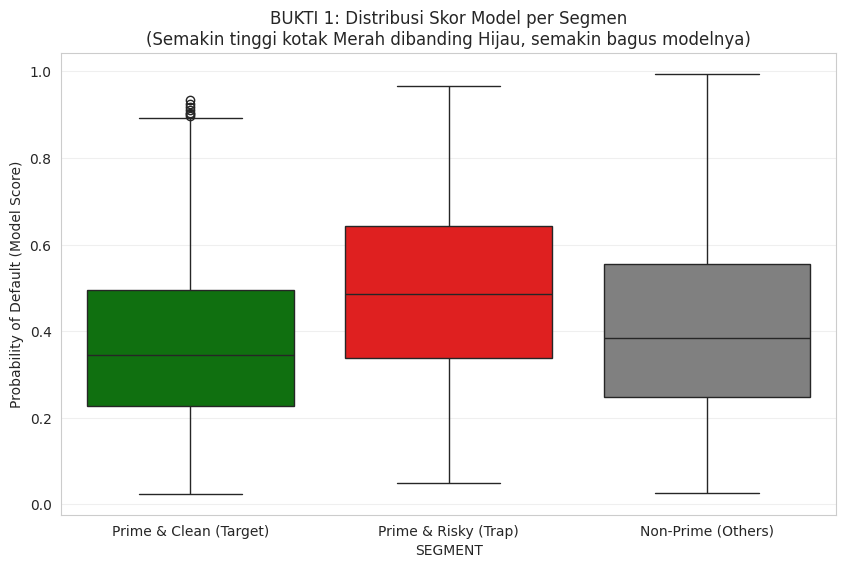


📊 BUKTI 2: UJI STATISTIK (MANN-WHITNEY U TEST)
   -> Rata-rata Skor 'Prime & Clean' : 0.3709
   -> Rata-rata Skor 'Prime & Risky' : 0.4941
   -> P-Value                        : 0.0000000000
   ✅ KESIMPULAN: Perbedaan SANGAT SIGNIFIKAN. Model terbukti membedakan kedua segmen.

📈 BUKTI 3: LIFT ANALYSIS (KEKUATAN SEGMENTASI)
   -> Default Rate Rata-rata Populasi : 8.07%
   -> Default Rate Segmen Risky       : 11.08%
   -> LIFT (Multiplier)               : 1.37x
   -> ARTINYA: Nasabah di segmen 'Risky' memiliki risiko 1.37 KALI LIPAT lebih tinggi
               daripada nasabah rata-rata.


In [ ]:
import scipy.stats as stats

# ==============================================================================
# PEMBUKTIAN KETAJAMAN MODEL (MODEL DISCRIMINATION PROOF)
# ==============================================================================

# 1. Persiapan Data (Menggunakan hasil prediksi validasi sebelumnya)
df_proof = X_val_split.copy()
df_proof['ACTUAL_TARGET'] = y_val_split
df_proof['MODEL_SCORE'] = y_pred_proba # Probabilitas dari Logistic Regression

# Definisi Ulang Segmen (Sama seperti sebelumnya)
def get_segment(row):
    if row['PRIME_WORKING_RISK_INTERACTION'] > 0:
        return 'Prime & Risky (Trap)'

    if (row['NAME_INCOME_TYPE'] == 'Working') and \
       (row['NAME_FAMILY_STATUS'] == 'Married') and \
       (row['NAME_HOUSING_TYPE'] == 'House / apartment'):
        return 'Prime & Clean (Target)'

    return 'Non-Prime (Others)'

df_proof['SEGMENT'] = df_proof.apply(get_segment, axis=1)

# ==============================================================================
# BUKTI 1: VISUAL (BOXPLOT)
# Hipotesis: Kotak 'Prime & Risky' harus berada JAUH DI ATAS 'Prime & Clean'
# ==============================================================================
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEGMENT', y='MODEL_SCORE', data=df_proof, palette={'Prime & Risky (Trap)': 'red', 'Prime & Clean (Target)': 'green', 'Non-Prime (Others)': 'gray'})
plt.title('BUKTI 1: Distribusi Skor Model per Segmen\n(Semakin tinggi kotak Merah dibanding Hijau, semakin bagus modelnya)')
plt.ylabel('Probability of Default (Model Score)')
plt.grid(axis='y', alpha=0.3)
plt.show()

# ==============================================================================
# BUKTI 2: STATISTIK (MANN-WHITNEY U TEST)
# Hipotesis Nol (H0): Tidak ada perbedaan risiko antara Prime Clean vs Prime Risky.
# Target: Kita ingin TOLAK H0 (P-Value < 0.05).
# ==============================================================================
group_clean = df_proof[df_proof['SEGMENT'] == 'Prime & Clean (Target)']['MODEL_SCORE']
group_risky = df_proof[df_proof['SEGMENT'] == 'Prime & Risky (Trap)']['MODEL_SCORE']

# Uji Mann-Whitney (Non-parametrik, aman untuk data skor yang tidak normal)
stat, p_value = stats.mannwhitneyu(group_risky, group_clean, alternative='greater')

print("\n📊 BUKTI 2: UJI STATISTIK (MANN-WHITNEY U TEST)")
print(f"   -> Rata-rata Skor 'Prime & Clean' : {group_clean.mean():.4f}")
print(f"   -> Rata-rata Skor 'Prime & Risky' : {group_risky.mean():.4f}")
print(f"   -> P-Value                        : {p_value:.10f}")

if p_value < 0.05:
    print("   ✅ KESIMPULAN: Perbedaan SANGAT SIGNIFIKAN. Model terbukti membedakan kedua segmen.")
else:
    print("   ❌ KESIMPULAN: Perbedaan TIDAK Signifikan. Model gagal membedakan segmen.")

# ==============================================================================
# BUKTI 3: BUSINESS PROOF (LIFT / MULTIPLIER)
# Seberapa kali lipat risiko di segmen Risky dibanding rata-rata?
# ==============================================================================
avg_default_rate = df_proof['ACTUAL_TARGET'].mean()
risky_default_rate = df_proof[df_proof['SEGMENT'] == 'Prime & Risky (Trap)']['ACTUAL_TARGET'].mean()

lift = risky_default_rate / avg_default_rate

print("\n📈 BUKTI 3: LIFT ANALYSIS (KEKUATAN SEGMENTASI)")
print(f"   -> Default Rate Rata-rata Populasi : {avg_default_rate*100:.2f}%")
print(f"   -> Default Rate Segmen Risky       : {risky_default_rate*100:.2f}%")
print(f"   -> LIFT (Multiplier)               : {lift:.2f}x")
print(f"   -> ARTINYA: Nasabah di segmen 'Risky' memiliki risiko {lift:.2f} KALI LIPAT lebih tinggi")
print(f"               daripada nasabah rata-rata.")

📊 BUSINESS IMPACT ANALYSIS: WORKING CLASS SEGMENT
                   SEGMENT  Total_Nasabah  Actual_Default_Rate (%)
        Non-Prime (Others)          42916                     7.66
Prime & Clean (The Target)           8250                     6.45
  Prime & Risky (The Trap)          10336                    11.08
------------------------------------------------------------
💰 HASIL SIMULASI (Skenario: Reject Segmen 'Prime & Risky')
   -> Total Aplikasi Ditolak      : 10,336 orang
   -> Kredit Macet Dicegah        : 1,145 orang
   -> TOTAL UANG DISELAMATKAN     : 643,696,623 (Currency Unit)


/tmp/ipython-input-1951640714.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=segment_stats, x='SEGMENT', y='Actual_Default_Rate (%)', palette=colors)


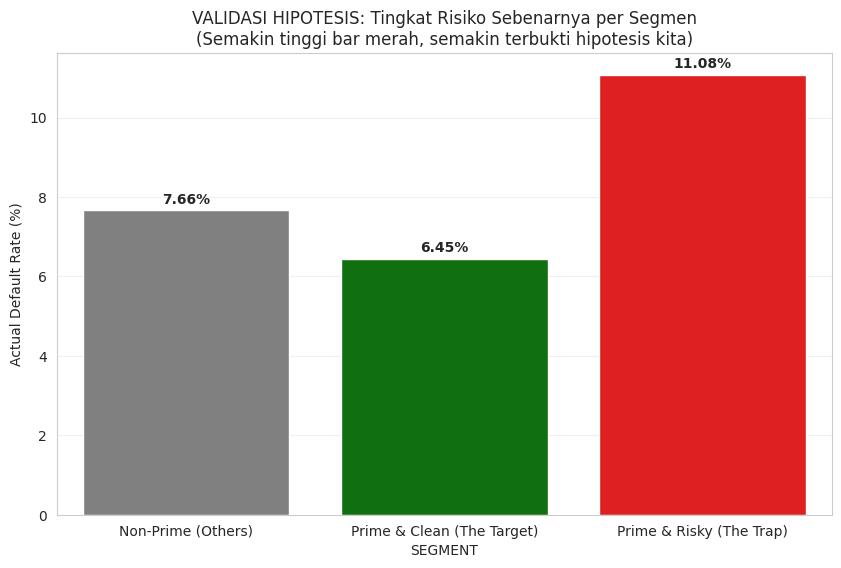

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gabungkan Data Validasi dengan Hasil Prediksi
df_impact = X_val_split.copy()
df_impact['ACTUAL_TARGET'] = y_val_split
df_impact['PREDICTED_PROBA'] = y_pred_proba

# 2. Definisi Segmen Working Class (Logika Bisnis)
def define_segment(row):
    # Jika fitur interaksi bernilai > 0, otomatis masuk kategori 'Jebakan' (Risky)
    if row['PRIME_WORKING_RISK_INTERACTION'] > 0:
        return 'Prime & Risky (The Trap)'

    # Cek profil Mapan tapi Bersih (Target Market Ideal)
    is_working = row['NAME_INCOME_TYPE'] == 'Working'
    is_married = row['NAME_FAMILY_STATUS'] == 'Married'
    is_house = row['NAME_HOUSING_TYPE'] == 'House / apartment'

    if is_working and is_married and is_house:
        return 'Prime & Clean (The Target)'

    return 'Non-Prime (Others)'

df_impact['SEGMENT'] = df_impact.apply(define_segment, axis=1)

# 3. Hitung Statistik Performa per Segmen
segment_stats = df_impact.groupby('SEGMENT').agg(
    Total_Nasabah=('ACTUAL_TARGET', 'count'),
    Actual_Default_Rate=('ACTUAL_TARGET', 'mean'),
    Avg_Model_Score=('PREDICTED_PROBA', 'mean')
).reset_index()

segment_stats['Actual_Default_Rate (%)'] = segment_stats['Actual_Default_Rate'] * 100

# 4. Simulasi Dampak Keuangan (Financial Impact)
# Skenario: Bank MENOLAK semua aplikasi dari segmen 'Prime & Risky'
risky_segment_data = df_impact[df_impact['SEGMENT'] == 'Prime & Risky (The Trap)']

# Hitung 'Loss Avoidance' (Uang pokok kredit macet yang berhasil diselamatkan)
defaulted_risky = risky_segment_data[risky_segment_data['ACTUAL_TARGET'] == 1]
potential_loss_saved = defaulted_risky['AMT_CREDIT'].sum()

# 5. Tampilkan Laporan Bisnis
print("=" * 60)
print("📊 BUSINESS IMPACT ANALYSIS: WORKING CLASS SEGMENT")
print("=" * 60)
print(segment_stats[['SEGMENT', 'Total_Nasabah', 'Actual_Default_Rate (%)']].to_string(index=False))
print("-" * 60)
print(f"💰 HASIL SIMULASI (Skenario: Reject Segmen 'Prime & Risky')")
print(f"   -> Total Aplikasi Ditolak      : {len(risky_segment_data):,} orang")
print(f"   -> Kredit Macet Dicegah        : {len(defaulted_risky):,} orang")
print(f"   -> TOTAL UANG DISELAMATKAN     : {potential_loss_saved:,.0f} (Currency Unit)")
print("=" * 60)

# 6. Visualisasi Bukti
plt.figure(figsize=(10, 6))
colors = {'Prime & Clean (The Target)': 'green',
          'Prime & Risky (The Trap)': 'red',
          'Non-Prime (Others)': 'gray'}

ax = sns.barplot(data=segment_stats, x='SEGMENT', y='Actual_Default_Rate (%)', palette=colors)
plt.title('VALIDASI HIPOTESIS: Tingkat Risiko Sebenarnya per Segmen\n(Semakin tinggi bar merah, semakin terbukti hipotesis kita)')
plt.ylabel('Actual Default Rate (%)')
plt.grid(axis='y', alpha=0.3)

# Label Angka
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f%%', padding=3, fontweight='bold')

plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

if 'X_train_split' not in locals():
    print("   -> Splitting ulang data (agar konsisten)...")
    X = df_train[final_features]
    y = df_train['TARGET']
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,
                                          max_depth=12,
                                          min_samples_leaf=10,
                                          class_weight='balanced',
                                          random_state=42,
                                          n_jobs=-1))
])

model_rf.fit(X_train_split, y_train_split)

y_pred_proba_rf = model_rf.predict_proba(X_val_split)[:, 1]
y_pred_class_rf = model_rf.predict(X_val_split)

rf_auc = roc_auc_score(y_val_split, y_pred_proba_rf)
print(f"\n📊 HASIL RANDOM FOREST:")
print(f"   ROC AUC Score : {rf_auc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_val_split, y_pred_class_rf))

print("\n🥊 HEAD-TO-HEAD COMPARISON:")
print(f"   Logistic Regression AUC : {roc_auc_score(y_val_split, y_pred_proba):.4f}") # Ambil skor LogReg sebelumnya
print(f"   Random Forest AUC       : {rf_auc:.4f}")

if rf_auc > roc_auc_score(y_val_split, y_pred_proba):
    print("   🏆 Pemenang: RANDOM FOREST")
else:
    print("   🏆 Pemenang: LOGISTIC REGRESSION")

🌲 Melatih Model Pembanding (Random Forest)...

📊 HASIL RANDOM FOREST:
   ROC AUC Score : 0.7448
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56537
           1       0.18      0.58      0.27      4965

    accuracy                           0.75     61502
   macro avg       0.57      0.67      0.56     61502
weighted avg       0.89      0.75      0.80     61502


🥊 HEAD-TO-HEAD COMPARISON:
   Logistic Regression AUC : 0.7508
   Random Forest AUC       : 0.7448
   🏆 Pemenang: LOGISTIC REGRESSION


# Problem Validation & Key Insight

🚀 Memulai Generasi Grafik Storytelling (Unified Logic)...
[1/5] Loading & Merging Data...
[2/5] Defining Analysis Segments...
[3/5] Generating Chart: The Approval Paradox...


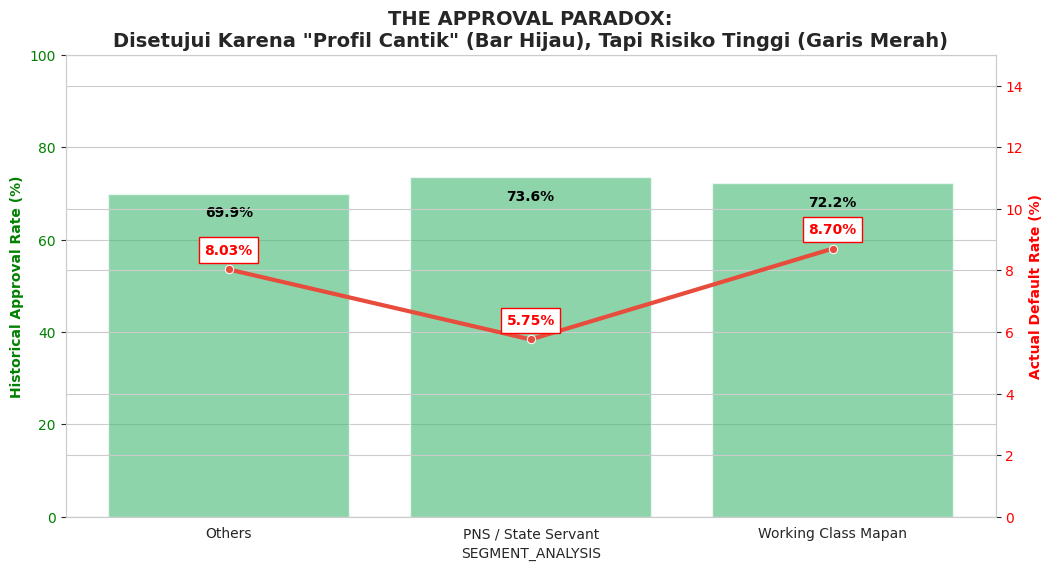

[4/5] Generating Chart: Insight 1 (Fragility Factor)...


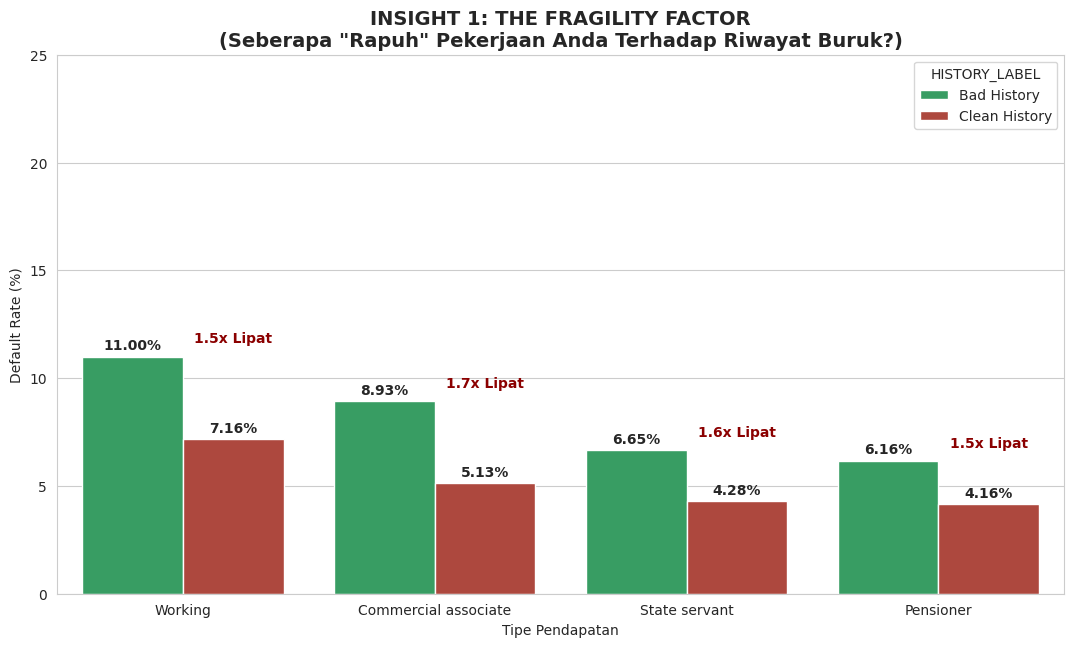

[5/5] Generating Chart: Insight 2 (Silent Accumulation)...


/tmp/ipython-input-4011140098.py:183: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=silent_stats, x='RISK_PROFILE', y='TARGET_PCT', palette='Reds')


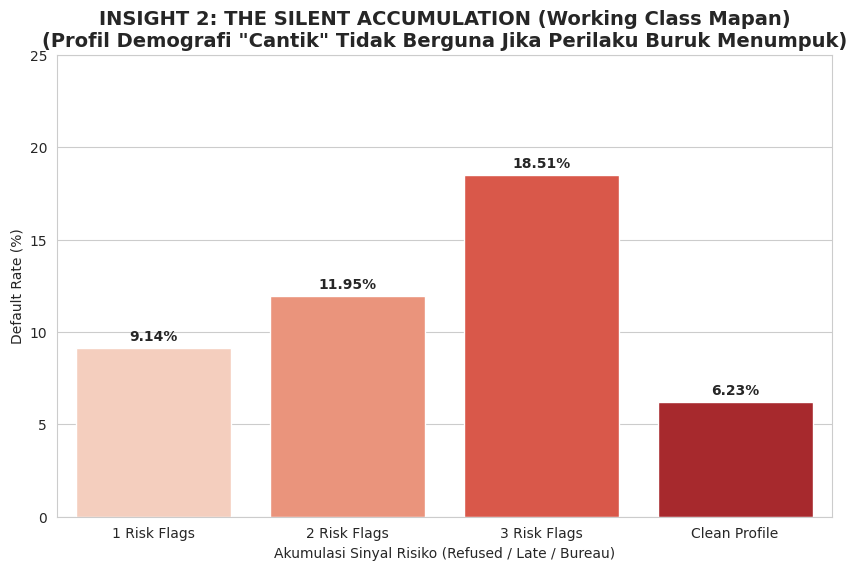


✅ SELESAI. Semua grafik sudah siap untuk slide presentasi.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:.2f}'.format


print("[1/5] Loading & Merging Data...")

try:
    df_train = pd.read_csv('application_train.csv')
    df_prev = pd.read_csv('previous_application.csv')
    df_bureau = pd.read_csv('bureau.csv')
    df_install = pd.read_csv('installments_payments.csv')
except FileNotFoundError:
    print("❌ Error: File CSV tidak ditemukan.")

# --- FEATURE ENGINEERING: 3 BAD FLAGS UTAMA ---
# Flag 1: Pernah Ditolak (Refused)
refused_agg = df_prev[df_prev['NAME_CONTRACT_STATUS'] == 'Refused'].groupby('SK_ID_CURR').size().reset_index(name='CNT_REFUSED')

# Flag 2: Pernah Telat Bayar (Late Payment)
df_install['IS_LATE'] = (df_install['DAYS_ENTRY_PAYMENT'] - df_install['DAYS_INSTALMENT']) > 0
late_agg = df_install.groupby('SK_ID_CURR')['IS_LATE'].max().reset_index(name='HAS_LATE_PAYMENT')

# Flag 3: Masalah Biro Kredit (Bureau Overdue)
bureau_agg = df_bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].max().reset_index(name='MAX_BUREAU_OVERDUE')

# Data Tambahan: Approval Rate Historis (Untuk Grafik Paradox)
approval_agg = df_prev.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].apply(
    lambda x: (x == 'Approved').mean()
).reset_index(name='HISTORICAL_APPROVAL_RATE')

df = df_train[['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']].copy()
df = df.merge(approval_agg, on='SK_ID_CURR', how='left')
df = df.merge(refused_agg, on='SK_ID_CURR', how='left')
df = df.merge(late_agg, on='SK_ID_CURR', how='left')
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')

cols_to_fill = ['HISTORICAL_APPROVAL_RATE', 'CNT_REFUSED', 'HAS_LATE_PAYMENT', 'MAX_BUREAU_OVERDUE']
df[cols_to_fill] = df[cols_to_fill].fillna(0)

df['TARGET_PCT'] = df['TARGET'] * 100
df['APPROVAL_PCT'] = df['HISTORICAL_APPROVAL_RATE'] * 100

# ------------------------------------------------------------------------------
# 2. DEFINISI SEGMEN
# ------------------------------------------------------------------------------
print("[2/5] Defining Analysis Segments...")

def get_segment(row):
    if (row['NAME_INCOME_TYPE'] == 'Working') and \
       (row['NAME_FAMILY_STATUS'] == 'Married') and \
       (row['NAME_HOUSING_TYPE'] == 'House / apartment'):
        return 'Working Class Mapan'

    if row['NAME_INCOME_TYPE'] == 'State servant':
        return 'PNS / State Servant'

    return 'Others'

df['SEGMENT_ANALYSIS'] = df.apply(get_segment, axis=1)

# ------------------------------------------------------------------------------
# 3. CHART 1: THE APPROVAL PARADOX
# ------------------------------------------------------------------------------
print("[3/5] Generating Chart: The Approval Paradox...")

paradox_stats = df.groupby('SEGMENT_ANALYSIS').agg(
    Avg_Approval_Rate=('APPROVAL_PCT', 'mean'),
    Default_Rate=('TARGET_PCT', 'mean')
).reset_index()

paradox_stats = paradox_stats[paradox_stats['SEGMENT_ANALYSIS'].isin(['Working Class Mapan', 'Others', 'PNS / State Servant'])]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=paradox_stats, x='SEGMENT_ANALYSIS', y='Avg_Approval_Rate', ax=ax1, color='#2ecc71', alpha=0.6)
ax1.set_ylabel('Historical Approval Rate (%)', color='green', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylim(0, 100)

ax2 = ax1.twinx()
sns.lineplot(data=paradox_stats, x='SEGMENT_ANALYSIS', y='Default_Rate', ax=ax2, color='#e74c3c', marker='o', linewidth=3)
ax2.set_ylabel('Actual Default Rate (%)', color='red', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 15)

plt.title('THE APPROVAL PARADOX:\nDisetujui Karena "Profil Cantik" (Bar Hijau), Tapi Risiko Tinggi (Garis Merah)', fontsize=14, fontweight='bold')

for i, row in paradox_stats.iterrows():
    ax1.text(i, row['Avg_Approval_Rate'] - 5, f"{row['Avg_Approval_Rate']:.1f}%", color='black', ha="center", fontweight='bold')
    ax2.text(i, row['Default_Rate'] + 0.5, f"{row['Default_Rate']:.2f}%", color='red', ha="center", fontweight='bold', bbox=dict(facecolor='white', edgecolor='red'))

plt.show()

# ------------------------------------------------------------------------------
# 4. CHART 2: INSIGHT 1 - THE FRAGILITY FACTOR (BY INCOME TYPE)
# ------------------------------------------------------------------------------
print("[4/5] Generating Chart: Insight 1 (Fragility Factor)...")

# Definisi Bad History (Gabungan 3 Flag)
df['HAS_BAD_HISTORY'] = ((df['CNT_REFUSED'] > 0) | (df['HAS_LATE_PAYMENT'] == 1) | (df['MAX_BUREAU_OVERDUE'] > 0)).astype(int)
df['HISTORY_LABEL'] = df['HAS_BAD_HISTORY'].map({0: 'Clean History', 1: 'Bad History'})

top_incomes = ['Working', 'Commercial associate', 'Pensioner', 'State servant']
df_fragility = df[df['NAME_INCOME_TYPE'].isin(top_incomes)].copy()

fragility_stats = df_fragility.groupby(['NAME_INCOME_TYPE', 'HISTORY_LABEL'])['TARGET_PCT'].mean().reset_index()

pivot_fragility = fragility_stats.pivot(index='NAME_INCOME_TYPE', columns='HISTORY_LABEL', values='TARGET_PCT')
pivot_fragility['Multiplier'] = pivot_fragility['Bad History'] / pivot_fragility['Clean History']
pivot_fragility = pivot_fragility.sort_values('Bad History', ascending=False).reset_index()

fragility_stats = fragility_stats.merge(pivot_fragility[['NAME_INCOME_TYPE']], on='NAME_INCOME_TYPE')

plt.figure(figsize=(13, 7))
ax = sns.barplot(data=fragility_stats, x='NAME_INCOME_TYPE', y='TARGET_PCT', hue='HISTORY_LABEL',
                 order=pivot_fragility['NAME_INCOME_TYPE'], palette=['#27ae60', '#c0392b'])

plt.title('INSIGHT 1: THE FRAGILITY FACTOR\n(Seberapa "Rapuh" Pekerjaan Anda Terhadap Riwayat Buruk?)', fontsize=14, fontweight='bold')
plt.ylabel('Default Rate (%)')
plt.xlabel('Tipe Pendapatan')
plt.ylim(0, 25) # Scale 0-25%

for i, inc in enumerate(pivot_fragility['NAME_INCOME_TYPE']):
    mult = pivot_fragility.loc[pivot_fragility['NAME_INCOME_TYPE'] == inc, 'Multiplier'].values[0]
    y_pos = pivot_fragility.loc[pivot_fragility['NAME_INCOME_TYPE'] == inc, 'Bad History'].values[0]
    plt.text(i + 0.2, y_pos + 0.5, f"{mult:.1f}x Lipat", ha='center', va='bottom', fontweight='bold', color='darkred')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontweight='bold')

plt.show()

# ------------------------------------------------------------------------------
# 5. CHART 3: INSIGHT 2 - THE SILENT ACCUMULATION
# ------------------------------------------------------------------------------
print("[5/5] Generating Chart: Insight 2 (Silent Accumulation)...")

# Hitung Jumlah Flag Risiko (0, 1, 2, 3)
df['RISK_FLAGS_COUNT'] = (df['CNT_REFUSED'] > 0).astype(int) + \
                         (df['HAS_LATE_PAYMENT'] > 0).astype(int) + \
                         (df['MAX_BUREAU_OVERDUE'] > 0).astype(int)

df['RISK_PROFILE'] = df['RISK_FLAGS_COUNT'].apply(lambda x: 'Clean Profile' if x == 0 else f'{x} Risk Flags')

df_silent = df[df['SEGMENT_ANALYSIS'] == 'Working Class Mapan'].copy()

silent_stats = df_silent.groupby('RISK_PROFILE')['TARGET_PCT'].mean().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=silent_stats, x='RISK_PROFILE', y='TARGET_PCT', palette='Reds')

plt.title('INSIGHT 2: THE SILENT ACCUMULATION (Working Class Mapan)\n(Profil Demografi "Cantik" Tidak Berguna Jika Perilaku Buruk Menumpuk)', fontsize=14, fontweight='bold')
plt.ylabel('Default Rate (%)')
plt.xlabel('Akumulasi Sinyal Risiko (Refused / Late / Bureau)')
plt.ylim(0, 25)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontweight='bold')

plt.show()

print("\n✅ SELESAI. Semua grafik sudah siap untuk slide presentasi.")